In [1]:
import os
import fire
import random
from retry.api import retry_call
from tqdm import tqdm
from datetime import datetime
from functools import wraps

import sys
sys.path.append("models/stylegan2/")
# from stylegan2 import Trainer, NanException
from sgan2 import Trainer
import sgan2

import torch
import torch.multiprocessing as mp
import torch.distributed as dist

import numpy as np


%load_ext autoreload
%autoreload 2

from setup import proj_dir, image_dir, out_dir, model_dir
import matplotlib.pyplot as plt
import torchvision.utils as vutils


In [2]:
device = torch.device("cuda:1")

In [3]:
data = image_dir+'zoom15_64/'
results_dir = out_dir
models_dir = model_dir
name = '2211-test'
new = False
load_from = 50
image_size = 128
network_capacity = 16
fmap_max = 512
transparent = False
batch_size = 32
gradient_accumulate_every = 6
num_train_steps = 50000
learning_rate = 2e-4
lr_mlp = 0.1
ttur_mult = 1.5
rel_disc_loss = False
num_workers =  None
save_every = 1000
evaluate_every = 1000
generate = False
num_generate = 1
generate_interpolation = False
interpolation_num_steps = 100
save_frames = False
num_image_tiles = 8
trunc_psi = 0.75
mixed_prob = 0.9
fp16 = False
no_pl_reg = False
cl_reg = False
fq_layers = []
fq_dict_size = 256
attn_layers = []
no_const = False
aug_prob = 0.
aug_types = ['translation', 'cutout']
top_k_training = False
generator_top_k_gamma = 0.99
generator_top_k_frac = 0.5
dual_contrast_loss = False
dataset_aug_prob = 0.
multi_gpus = False
calculate_fid_every = None
calculate_fid_num_images = 12800
clear_fid_cache = False
seed = 42
log = False
rank = 1

In [4]:
model_args = dict(
    name = name,
    results_dir = results_dir,
    models_dir = models_dir,
    batch_size = batch_size,
    gradient_accumulate_every = gradient_accumulate_every,
    image_size = image_size,
    network_capacity = network_capacity,
    fmap_max = fmap_max,
    transparent = transparent,
    lr = learning_rate,
    lr_mlp = lr_mlp,
    ttur_mult = ttur_mult,
    rel_disc_loss = rel_disc_loss,
    num_workers = num_workers,
    save_every = save_every,
    evaluate_every = evaluate_every,
    num_image_tiles = num_image_tiles,
    trunc_psi = trunc_psi,
    fp16 = fp16,
    no_pl_reg = no_pl_reg,
    cl_reg = cl_reg,
    fq_layers = fq_layers,
    fq_dict_size = fq_dict_size,
    attn_layers = attn_layers,
    no_const = no_const,
    aug_prob = aug_prob,
    aug_types = aug_types,
    top_k_training = top_k_training,
    generator_top_k_gamma = generator_top_k_gamma,
    generator_top_k_frac = generator_top_k_frac,
    dual_contrast_loss = dual_contrast_loss,
    dataset_aug_prob = dataset_aug_prob,
    calculate_fid_every = calculate_fid_every,
    calculate_fid_num_images = calculate_fid_num_images,
    clear_fid_cache = clear_fid_cache,
    mixed_prob = mixed_prob,
    log = log,
    rank = rank,
)

In [5]:
model = Trainer(**model_args)
model.load(load_from)

/home/jtl/Dropbox (MIT)/project_image_demand/results/sGAN2/2211-test
/dreambig/qingyi/image_chicago/models/sGAN2/2211-test
loading from version 1.8.9


In [6]:
# Load classification (regression) model

from util_model import load_model

data_config = {}
data_config['demo_channels'] = 5
data_config['image_size']= 64
config = {'data_config': data_config}
clf = load_model('mobilenet', 'MobileNetV2', config)
# clf = clf.to(device)

clf_model_path = model_dir+"CLF_2211-3-7-128_35.pt"
clf_saved = torch.load(clf_model_path)
clf.load_state_dict(clf_saved['model_state_dict'])

<All keys matched successfully>

In [7]:
def generate_new(num_gen):
    
    style = sgan2.noise_list(n=num_gen, layers=6, latent_dim=512, device=device)
    w_space = sgan2.latent_to_w(model.GAN.S, style)
    w_truncated = model.truncate_style_defs(w_space, trunc_psi = 0.8)
    w_styles = sgan2.styles_def_to_tensor(w_truncated)

    n = sgan2.image_noise(num_gen, 128, device=device)

    generated_images = model.GAN.G(w_styles, n)

    # plt.figure(figsize=(8,8))
    # plt.axis("off")
    # plt.imshow(np.transpose(vutils.make_grid(generated_images, padding=2, normalize=True, nrows=2).cpu(),(1,2,0)));

    return w_truncated[0][0].detach().cpu().numpy(), clf(generated_images.cpu()).detach().numpy()

In [8]:
generated_demo = []
w_truncated = []
for i in range(5):
    print(i)
    w, d = generate_new(64)
    generated_demo.append(d)
    w_truncated.append(w)

0
1
2
3
4


In [9]:
generated_demo = np.concatenate(generated_demo)
w_truncated = np.concatenate(w_truncated)

In [40]:
move_dir = []
for i in range(5):
    high = np.array(generated_demo[:,i]>np.percentile(generated_demo[:,i], 95))

    high_w = w_truncated[high, :]

    low = np.array(generated_demo[:,i]<np.percentile(generated_demo[:,i], 5))

    low_w = w_truncated[low, :]

    high_w = high_w.mean(axis=0)
    low_w = low_w.mean(axis=0)
    move_dir.append(high_w - low_w)

In [35]:
def generate_modified(num_gen, move_dir):
    
    style = sgan2.noise_list(n=8, layers=6, latent_dim=512, device=device)
    w_space = sgan2.latent_to_w(model.GAN.S, style)
    w_truncated = model.truncate_style_defs(w_space, trunc_psi = 0.8)

    n = sgan2.image_noise(8, 128, device=device)
    move_dir = torch.tensor(move_dir).to(device)
    
    w_truncated = [(torch.cat([w_truncated[0][0]+move_dir, w_truncated[0][0]+0.5*move_dir, 
                           w_truncated[0][0], 
                           w_truncated[0][0]-0.5*move_dir, w_truncated[0][0]-move_dir]), 6)]
    
    w_styles = sgan2.styles_def_to_tensor(w_truncated)
    
    n=n.repeat(5,1,1,1)
    
    generated_images = model.GAN.G(w_styles, n)

    return generated_images.cpu().detach()

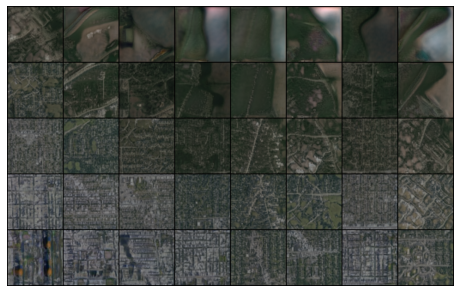

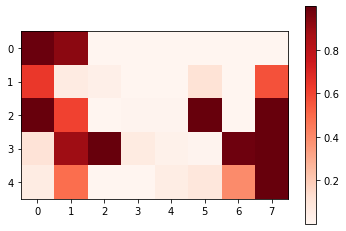

In [43]:
# income
generated_images = generate_modified(8, move_dir[0])

plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_images, padding=2, normalize=True, nrows=2).cpu(),(1,2,0)));

plt.figure()
plt.imshow(clf(generated_images)[:,1].reshape(5,8).detach().numpy(), cmap='Reds')
plt.colorbar();

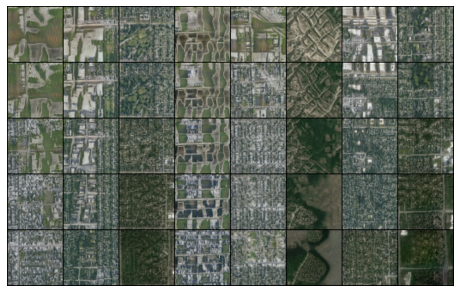

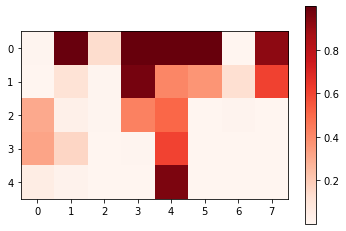

In [44]:
# population density

generated_images = generate_modified(8, move_dir[1])

plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_images, padding=2, normalize=True, nrows=2).cpu(),(1,2,0)));

plt.figure()
plt.imshow(clf(generated_images)[:,1].reshape(5,8).detach().numpy(), cmap='Reds')
plt.colorbar();

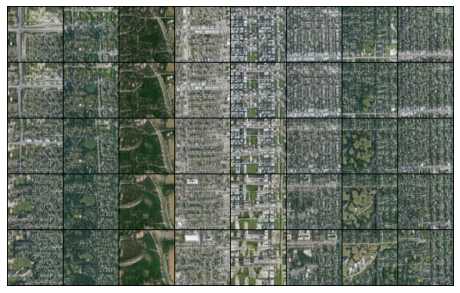

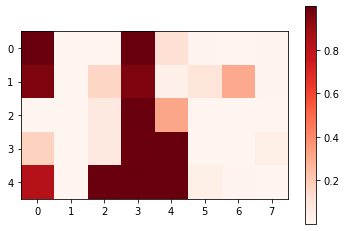

In [45]:
# pct senior
generated_images = generate_modified(8, move_dir[2])

plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_images, padding=2, normalize=True, nrows=2).cpu(),(1,2,0)));

plt.figure()
plt.imshow(clf(generated_images)[:,1].reshape(5,8).detach().numpy(), cmap='Reds')
plt.colorbar();

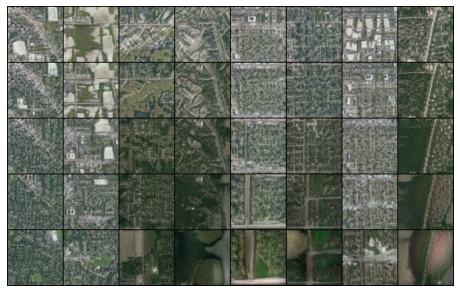

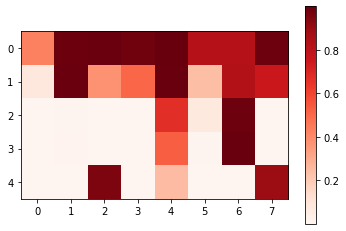

In [47]:
# pct young adults (25-34yrs)
generated_images = generate_modified(8, move_dir[3])

plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_images, padding=2, normalize=True, nrows=2).cpu(),(1,2,0)));

plt.figure()
plt.imshow(clf(generated_images)[:,1].reshape(5,8).detach().numpy(), cmap='Reds')
plt.colorbar();

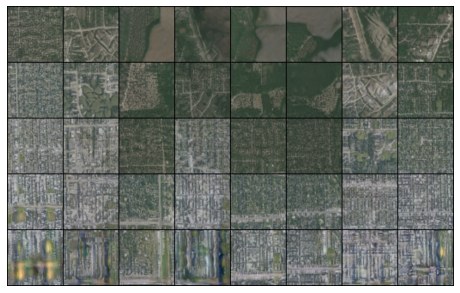

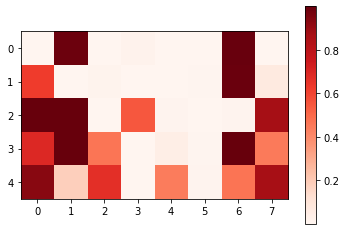

In [46]:
# Education
generated_images = generate_modified(8, move_dir[4])

plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_images, padding=2, normalize=True, nrows=2).cpu(),(1,2,0)));

plt.figure()
plt.imshow(clf(generated_images)[:,1].reshape(5,8).detach().numpy(), cmap='Reds')
plt.colorbar();

In [9]:
def run_training(rank, world_size, model_args, data, load_from, new, num_train_steps, name, seed):
    is_main = rank == 0
    is_ddp = world_size > 1

    if is_ddp:
        set_seed(seed)
        os.environ['MASTER_ADDR'] = 'localhost'
        os.environ['MASTER_PORT'] = '12355'
        dist.init_process_group('nccl', rank=rank, world_size=world_size)

        print(f"{rank + 1}/{world_size} process initialized.")

    model_args.update(
        is_ddp = is_ddp,
        rank = rank,
        world_size = world_size
    )

    model = Trainer(**model_args)
    model.write_config()
    print(model.config_path)
    return 
    
    if not new:
        model.load(load_from)
    else:
        model.clear()

    model.set_data_src(data)

    progress_bar = tqdm(initial = model.steps, total = num_train_steps, mininterval=10., desc=f'{name}<{data}>')
    while model.steps < num_train_steps:
        retry_call(model.train, tries=3, exceptions=NanException)
        progress_bar.n = model.steps
        progress_bar.refresh()
        if is_main and model.steps % 50 == 0:
            model.print_log()

    model.save(model.checkpoint_num)

    if is_ddp:
        dist.destroy_process_group()

In [10]:
rank = 0
world_size = 1

run_training(rank, world_size, model_args, data, load_from, new, num_train_steps, name, seed)

/dreambig/qingyi/image_chicago/models/2211-test/.config.json


In [3]:
if generate:
    model = Trainer(**model_args)
    model.load(load_from)
    samples_name = timestamped_filename()
    for num in tqdm(range(num_generate)):
        model.evaluate(f'{samples_name}-{num}', num_image_tiles)
    print(f'sample images generated at {results_dir}/{name}/{samples_name}')
    return

if generate_interpolation:
    model = Trainer(**model_args)
    model.load(load_from)
    samples_name = timestamped_filename()
    model.generate_interpolation(samples_name, num_image_tiles, num_steps = interpolation_num_steps, save_frames = save_frames)
    print(f'interpolation generated at {results_dir}/{name}/{samples_name}')
    return

_StoreAction(option_strings=['--dis_optim_file'], dest='dis_optim_file', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, help='saved_state of discriminator optimizer', metavar=None)